### Goal
This notebook tries to recreate Drone classification using RF signal based spectral features by Kılıç
Date: June 20, 2022

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import os
from sklearn.model_selection import train_test_split

from spafe.features.lfcc import lfcc
import spafe.utils.vis as vis

from scipy.signal import get_window

import scipy.fftpack as fft

In [2]:
# Data Location
data_folder = '/home/kzhou/Data/DroneRF/'

fs = 40e6 #40 MHz

file_names_h = os.listdir(data_folder+'High/')
file_names_l = os.listdir(data_folder+'Low/')

file_names_h.sort()
file_names_l.sort()

# # Test the file names are aligned
# for i in range(len(file_names_h)):
#     print('High:',file_names_h[i], '\t Low:', file_names_l[i])

### 1. Feature Generation

In [3]:
# 1st implmentation using libraries

def get_features(rf_data, feat_name):
    if feat_name == 'PSD':
        f, Pxx_den = signal.welch(rf_data, fs, window='hamming', nperseg=4096)
        return Pxx_den
    if feat_name == 'LFCC':
        n_coefficients = 12
        lfccs  = lfcc(rf_data, len(rf_data_h)/0.25, n_coefficients, win_len=0.24) # need to make M=1, but winlen = 0.25 gives error
        return lfccs[0]
    if feat_name == 'MFCC':
#         n_coefficients = 12
#         mfccs = librosa.feature.mfcc(rf_data, sr=fs, n_mfcc=n_coefficients, dct_type=2)
        freq_min = 0
        freq_high = fs / 2
        mel_filter_num = 10

        return mfccs

#### Ceptral Coefficients Libraries

LFCC: https://spafe.readthedocs.io/en/latest/features/lfcc.html <br />
MFCC: https://librosa.org/doc/latest/generated/librosa.feature.mfcc.html?highlight=mfcc

In [4]:
# Helper functions for self implementation

def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect') # padding an extra frame at the beginning & end
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
#     print("MEL min: {0}".format(fmin_mel))
#     print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n]-filter_points[0]: filter_points[n + 1]-filter_points[0]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1]-filter_points[0]: filter_points[n + 2]-filter_points[0]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [5]:
# self implementation based on tutorial
def get_features_2(rf_data, feat_name, hl):
    FFT_size = 4096
    fs = 40e6
    # 1. split into frames
    if feat_name == 'PSD':
        rf_framed = frame_audio(rf_data, FFT_size, hop_size=220, sample_rate=fs)
    if feat_name == 'MFCC':
        rf_framed = frame_audio(rf_data, FFT_size, hop_size=255, sample_rate=fs) # just for one frame
    
    # 2. get windows
    window = get_window("hamming", FFT_size, fftbins=True)
    rf_win = rf_framed * window

    # 3. apply FFT
    rf_winT = np.transpose(rf_win)
    rf_fft = np.empty((int(1 + FFT_size // 2), rf_winT.shape[1]), dtype=np.complex64, order='F') #shape: (number of frames, fft/2)

    for n in range(rf_fft.shape[1]): # for each of the frames
        rf_fft[:, n] = fft.fft(rf_winT[:, n], axis=0)[:rf_fft.shape[0]] # calc fft and take the first half of freq (positive)

    rf_fft = np.transpose(rf_fft)
    
    # Calculate PSD
    if feat_name == 'PSD':
#         rf_power = np.square(np.abs(rf_fft))/(FFT_size/2)
#         ## Average across the frames
        rf_power = np.square(np.abs(rf_fft))
        psd = np.mean(rf_power, axis =0)
        
        return psd
    
    # MFCC & LFCC
    if feat_name == 'MFCC':
        if hl == 'l':
            freq_min = 2400e6
            freq_high = 2420e6 # half way to 2440
            mel_filter_num = 10 # F
        else:
            freq_min = 2440e6
            freq_high = 2460e6 # half way to 2480
            mel_filter_num = 10
        
        # setup the filters
        # debug to prints
#         print(freq_min)
#         print(freq_high)
#         print(mel_filter_num)
#         print(FFT_size)
#         print(fs)
        
        filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=fs)
#         print(filter_points)
#         print(fs)
#         print(freq_high)
        filters = get_filters(filter_points, FFT_size)
        
        # apply the filters
        rf_power = np.square(np.abs(rf_fft))
        audio_filtered = np.dot(filters, np.transpose(rf_power))
        audio_log = 10.0 * np.log10(audio_filtered)
        
        # apply dct
        dct_filter_num = 12
        dct_filters = dct(dct_filter_num, mel_filter_num)
        cepstral_coefficents = np.dot(dct_filters, audio_log)
        return cepstral_coefficents
    
    

In [7]:
Xlow = [] # Low freq features
Xhigh = [] 

ys = [] # labels - 2 class
y4s = [] # labels - 4 class
y10s = [] # labels - 10 classes


for i in range(len(file_names_h)):

    # load RF data
    rf_data_h = pd.read_csv(data_folder+'High/'+file_names_h[i], header=None).values
    rf_data_h = rf_data_h.flatten()
    
    rf_data_l = pd.read_csv(data_folder+'Low/'+file_names_l[i], header=None).values
    rf_data_l = rf_data_l.flatten()
    
    # add features
    Xhigh.append(get_features(rf_data_h, 'PSD'))
    Xlow.append(get_features(rf_data_l, 'PSD'))
#     Xhigh.append(get_features_2(rf_data_h, 'MFCC', 'h'))
#     Xlow.append(get_features_2(rf_data_l, 'MFCC', 'l'))
    
    ## Labels
    ys.append(int(file_names_h[i][0])) # 2 class
    y4s.append(int(file_names_h[i][:3])) # 4 class
    y10s.append(int(file_names_h[i][:5])) # 10 class
    
    if int(file_names_h[i][:5])!= int(file_names_l[i][:5]):
        raise Exception("File labels do not match")
    

In [12]:
# change lists to arrays and make it stackable
Xh_arr = np.array(Xhigh)
Xh_arr.shape
Xh_arr = Xh_arr.reshape(227,Xh_arr.shape[1])

Xl_arr = np.array(Xlow)
Xl_arr.shape
Xl_arr = Xl_arr.reshape(227,Xl_arr.shape[1])

y_arr = np.array(y4s)

# combine Low and High mats
Xhl_arr = np.concatenate([Xl_arr,Xh_arr], axis=1)


In [ ]:
# check data dimension
Xh_arr.shape

### 2. K-fold SVM classifier

In [9]:
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# split data into K-fold
k_fold = 10
cv = KFold(n_splits=k_fold, random_state=1, shuffle=True)

# model parameters
Cs=list(map(lambda x:pow(2,x),range(-15,16,1)))
gammas=list(map(lambda x:pow(2,x),range(-15,16,1)))

# which freq range
Xs_arr = Xl_arr # Xl_arr, Xhl_arrb
ys_arr = y_arr

In [10]:
best_params_ls = []
score_ls = []
for train_ix, test_ix in cv.split(Xs_arr):
    
    # find the optimal hypber parameters
    parameters = {'C':Cs, 'gamma':gammas}
    svc = svm.SVC(kernel='rbf')
    clf = GridSearchCV(svc, parameters, n_jobs=1)
    clf.fit(Xs_arr[train_ix], y_arr[train_ix])
    
    print(clf.best_params_)
    best_params_ls.append(clf.best_params_)
    
    # predict on the test data
    y_pred = clf.predict(Xs_arr[test_ix])
    acc = accuracy_score(y_arr[test_ix], y_pred)
    print(acc)
    score_ls.append(acc)
    
    

{'C': 0.5, 'gamma': 0.125}
0.8260869565217391
{'C': 1, 'gamma': 0.25}
0.7391304347826086
{'C': 16384, 'gamma': 0.0009765625}
0.7391304347826086
{'C': 4096, 'gamma': 0.00048828125}
1.0
{'C': 0.5, 'gamma': 0.0625}
0.8695652173913043
{'C': 256, 'gamma': 0.001953125}
0.8695652173913043
{'C': 256, 'gamma': 0.001953125}
0.782608695652174
{'C': 16384, 'gamma': 0.000244140625}
0.8181818181818182
{'C': 4, 'gamma': 0.015625}
0.7272727272727273
{'C': 2, 'gamma': 0.015625}
0.8181818181818182


## Results
Using PSD: High = 0.973517786561265, Low = 0.7800395256916997, HighLow = 0.9956521739130434

Using LFCC: High = 0.86, HighLow = 0.84, Low 0.81

In [11]:
np.mean(score_ls) # High frequency only

0.8189723320158102

In [62]:
np.mean(score_ls) # High & Low frequency only

0.8413043478260869

In [65]:
np.mean(score_ls) # Low frequency only

0.8189723320158102

### Debugging

In [ ]:
from sklearn import preprocessing
LE = preprocessing.LabelEncoder()
y_int = LE.fit_transform(y_arr)

In [20]:
### visualize the signals and compare to figure 3 of paper
# find indices of each of the 4 modes
ix_nds = []
for d in range(4):
    ix_nds.append(np.where(y_int==d))

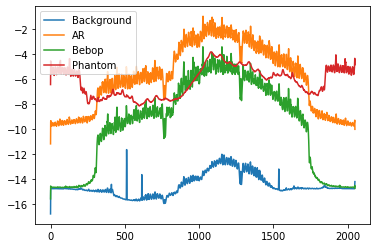

In [25]:
for d in range(4):
    avg_psd_onedrone = np.mean(Xl_arr[ix_nds[d]], axis=0)
    plt.plot(np.log(avg_psd_onedrone)) # figure out how to calculate decibels
    
plt.legend(['Background', 'AR', 'Bebop', 'Phantom'])